# Бинарная классификация: детекция матчей при сопоставлении товаров

**Задача**

Для решения задачи предоставлены обезличенные данные по товарным предложениям продавцов (offer) и товарам ассортимента маркетплейса "Мегамаркет" (goods).
В данных для каждого предложения уже найдены ближайшие товары из ассортимента и указаны основные признаки для этой пары. **Необходимо только классифицировать, какая из пар является матчем, а какая — нет.**

**Признаки**
- `offer_depersanalised` - идентификаторы предложения
- `goods_depersanalised` - идентификаторы товара
- `sum_length` - суммарная длина пары названий и атрибутов в символах
- `attrs+title_score` - вероятность матча от рескоринговой модели
- `offer_price` - цена предложения
- `item_price` - цена товара
- `goods_category_id` - категория товара
- `id` - идентификатор пары offer_depersanalised + $ + goods_depersanalised
- `target` (только в train.csv) - метка класса (0 - не матч, 1 - матч)

**Эмбеддинги**

- `goods_image_vectors и offer_image_vectors` - содержат файлы с векторами изображений (*embed_deperson.npy*) и их идентификаторами (*items_deperson.npy*) для товаров ассортимента и предложений соответственно. Объекты в файлах соотносятся 1 к 1
- `goods_title_vectors и offer_title_vectors` - содержат файлы с векторами названий+атрибутов (*embed_deperson.npy*) и их идентификаторами (*items_deperson.npy*) для товаров ассортимента и предложений соответственно. Объекты в файлах соотносятся 1 к 1

**Краткий план действий**

1. Осмотр данных
2. Предобработка признаков и эмбеддингов
3. Feature engineering, тестирование моделей и подбор оптимальных параметров
4. Тестирование финальной модели

## Загрузка и осмотр данных

In [10]:
# устанавливаем модуль kaggle
%pip install -q kaggle

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [11]:
# загружаем датасеты соревнования
import os
os.environ['KAGGLE_USERNAME'] = "******"
os.environ['KAGGLE_KEY'] = "*****************************"
!kaggle competitions download -c binary-classification-offers-on-the-marketplace

100%|██████████| 989M/989M [00:31<00:00, 32.8MB/s] 


In [3]:
# распаковываем архив
!unzip -o binary-classification-offers-on-the-marketplace.zip

Archive:  binary-classification-offers-on-the-marketplace.zip
  inflating: goods_image_vectors/goods_image_vectors/embed_deperson.npy  
  inflating: goods_image_vectors/goods_image_vectors/items_deperson.npy  
  inflating: goods_title_vectors/goods_title_vectors/embed_deperson.npy  
  inflating: goods_title_vectors/goods_title_vectors/items_deperson.npy  
  inflating: offer_image_vectors/offer_image_vectors/embed_deperson.npy  
  inflating: offer_image_vectors/offer_image_vectors/items_deperson.npy  
  inflating: offer_title_vectors/offer_title_vectors/embed_deperson.npy  
  inflating: offer_title_vectors/offer_title_vectors/items_deperson.npy  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [1]:
# загружаем необходимые библиотеки и модули 

%pip install catboost
%pip install optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import optuna
import optuna.logging
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# сохраняем датасеты и массивы в переменные
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
goods_image_vectors = np.load('goods_image_vectors/goods_image_vectors/embed_deperson.npy')
goods_image_vectors_id = np.load('goods_image_vectors/goods_image_vectors/items_deperson.npy')
goods_title_vectors = np.load('goods_title_vectors/goods_title_vectors/embed_deperson.npy')
goods_title_vectors_id = np.load('goods_title_vectors/goods_title_vectors/items_deperson.npy')
offer_image_vectors = np.load('offer_image_vectors/offer_image_vectors/embed_deperson.npy')
offer_image_vectors_id = np.load('offer_image_vectors/offer_image_vectors/items_deperson.npy')
offer_title_vectors = np.load('offer_title_vectors/offer_title_vectors/embed_deperson.npy')
offer_title_vectors_id = np.load('offer_title_vectors/offer_title_vectors/items_deperson.npy')

In [3]:
# проверим объем данных 
print("Объем данных в обучающей выборке:",train.shape) 
print("Объем данных в тестовой выборке:",test.shape)
print("Объем данных в sample_submission:",sample_submission.shape)

Объем данных в обучающей выборке: (2518441, 9)
Объем данных в тестовой выборке: (363835, 8)
Объем данных в sample_submission: (363835, 2)


In [4]:
# функция для получения общей информации о датасете

def info (df):
    print(40*' ','Первые 10 строк датасета')
    display(df.head(10))
    print(100*'*')
    print(40*' ','Информация о типах и количестве данных')
    print('')
    display(df.info())
    print(100*'*')
    print(40*' ','Описательные статистики')
    display(df.describe())
    print(100*'*')
    print('Количество явных дубликатов:',df.duplicated().sum())
    print('Количество пропусков:')
    print(df.isna().sum())
    print(100*'*')
    df.hist(figsize=(20,10),bins=100)
        
# функция для получения общей информации о массиве      

def info_array(array_dict):
    for name, arr in array_dict.items():
        print(f"{name}:")
        print("Объем массива:", arr.shape)
        print("Тип данных массива:", arr.dtype)
        print("Размерность массива:", arr.ndim)
        
        is_normalized = np.allclose(np.linalg.norm(arr), 1)

        if is_normalized:
            print("Массив нормализован.")
        else:
            print("Массив не нормализован.")
        print('*'*100)

                                         Первые 10 строк датасета


,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
0,295140,1396793,37,0.027267,1070,NaN,14.0,0,295140$1396793
1,65291,1396586,38,0.050415,698,NaN,14.0,0,65291$1396586
2,39232,1396244,38,0.087280,837,NaN,14.0,0,39232$1396244
3,39232,1396513,38,0.087280,837,NaN,14.0,0,39232$1396513
4,65052,1396237,38,0.079773,1085,NaN,14.0,0,65052$1396237
5,90396,1396237,38,0.079773,350,NaN,14.0,0,90396$1396237
6,373848,1396822,39,0.000035,1391,NaN,14.0,0,373848$1396822
7,295140,1396237,39,0.065979,1070,NaN,14.0,0,295140$1396237
8,142712,717657,40,0.000370,14566,31840.0,2.0,0,142712$717657
9,64799,1396335,40,0.047699,348,NaN,14.0,0,64799$1396335


****************************************************************************************************
                                         Информация о типах и количестве данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518441 entries, 0 to 2518440
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   offer_depersanalised  int64  
 1   goods_depersanalised  int64  
 2   sum_length            int64  
 3   attrs+title_score     float64
 4   offer_price           int64  
 5   goods_price           float64
 6   goods_category_id     float64
 7   target                int64  
 8   id                    object 
dtypes: float64(3), int64(5), object(1)
memory usage: 172.9+ MB


None

****************************************************************************************************
                                         Описательные статистики


,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target
count,2.518441e+06,2.518441e+06,2.518441e+06,2.518441e+06,2.518441e+06,2.111154e+06,2.517608e+06,2.518441e+06
mean,2.861906e+05,8.761657e+05,5.870672e+02,1.287538e-01,9.362961e+05,4.798429e+04,4.873336e+12,1.169942e-01
std,1.653314e+05,5.122913e+05,4.265811e+02,2.644693e-01,9.569629e+06,7.939302e+06,1.094651e+14,3.214134e-01
min,0.000000e+00,0.000000e+00,3.700000e+01,3.147125e-05,1.010000e+02,1.010000e+02,2.000000e+00,0.000000e+00
25%,1.429530e+05,4.234650e+05,2.310000e+02,3.564358e-05,9.900000e+02,6.650000e+02,5.000000e+00,0.000000e+00
50%,2.864410e+05,8.708360e+05,5.070000e+02,1.080632e-04,2.838000e+03,1.780000e+03,6.000000e+00,0.000000e+00
75%,4.292430e+05,1.307631e+06,8.070000e+02,5.282593e-02,9.300000e+03,6.516000e+03,1.400000e+01,0.000000e+00
max,5.727660e+05,1.760567e+06,7.829000e+03,9.975586e-01,1.000001e+08,2.106021e+09,2.463685e+15,1.000000e+00


****************************************************************************************************
Количество явных дубликатов: 0
Количество пропусков:
offer_depersanalised         0
goods_depersanalised         0
sum_length                   0
attrs+title_score            0
offer_price                  0
goods_price             407287
goods_category_id          833
target                       0
id                           0
dtype: int64
****************************************************************************************************


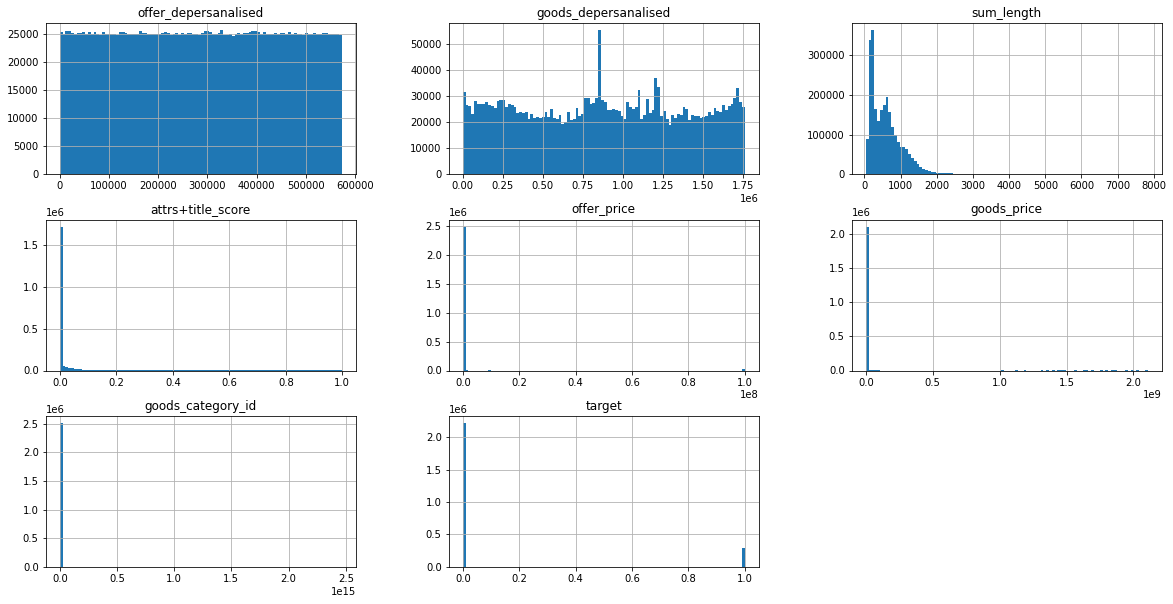

In [5]:
# общая информация по обучающей выборке
info(train)

                                         Первые 10 строк датасета


,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,id
0,64819,1396468,38,0.046997,368,NaN,14.0,64819$1396468
1,64819,1396235,38,0.046997,368,NaN,14.0,64819$1396235
2,64819,1396318,38,0.046997,368,NaN,14.0,64819$1396318
3,359959,1396281,40,0.060211,634,NaN,14.0,359959$1396281
4,142700,717657,40,0.000370,14924,31840.0,2.0,142700$717657
5,142713,717657,40,0.000370,13759,31840.0,2.0,142713$717657
6,230214,717657,40,0.000370,17595,31840.0,2.0,230214$717657
7,106880,1396551,40,0.043274,357,NaN,14.0,106880$1396551
8,460062,1396292,41,0.000085,927,NaN,14.0,460062$1396292
9,142719,717657,47,0.000036,8600,31840.0,2.0,142719$717657


****************************************************************************************************
                                         Информация о типах и количестве данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363835 entries, 0 to 363834
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   offer_depersanalised  363835 non-null  int64  
 1   goods_depersanalised  363835 non-null  int64  
 2   sum_length            363835 non-null  int64  
 3   attrs+title_score     363835 non-null  float64
 4   offer_price           363835 non-null  int64  
 5   goods_price           304864 non-null  float64
 6   goods_category_id     363704 non-null  float64
 7   id                    363835 non-null  object 
dtypes: float64(3), int64(4), object(1)
memory usage: 22.2+ MB


None

****************************************************************************************************
                                         Описательные статистики


,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id
count,363835.000000,3.638350e+05,363835.000000,363835.000000,3.638350e+05,3.048640e+05,3.637040e+05
mean,286850.598678,8.771147e+05,583.423703,0.128098,9.583577e+05,3.089512e+04,5.100726e+12
std,165256.359873,5.118925e+05,423.870065,0.264238,9.683426e+06,5.866152e+06,1.119848e+14
min,1.000000,1.800000e+01,38.000000,0.000032,1.010000e+02,1.010000e+02,2.000000e+00
25%,144092.000000,4.249365e+05,231.000000,0.000035,9.820000e+02,6.630000e+02,5.000000e+00
50%,286456.000000,8.707780e+05,504.000000,0.000103,2.832000e+03,1.770000e+03,6.000000e+00
75%,429787.000000,1.307888e+06,800.000000,0.050140,9.321000e+03,6.550000e+03,1.400000e+01
max,572765.000000,1.760562e+06,6175.000000,0.997070,1.000001e+08,1.638016e+09,2.463685e+15


****************************************************************************************************
Количество явных дубликатов: 0
Количество пропусков:
offer_depersanalised        0
goods_depersanalised        0
sum_length                  0
attrs+title_score           0
offer_price                 0
goods_price             58971
goods_category_id         131
id                          0
dtype: int64
****************************************************************************************************


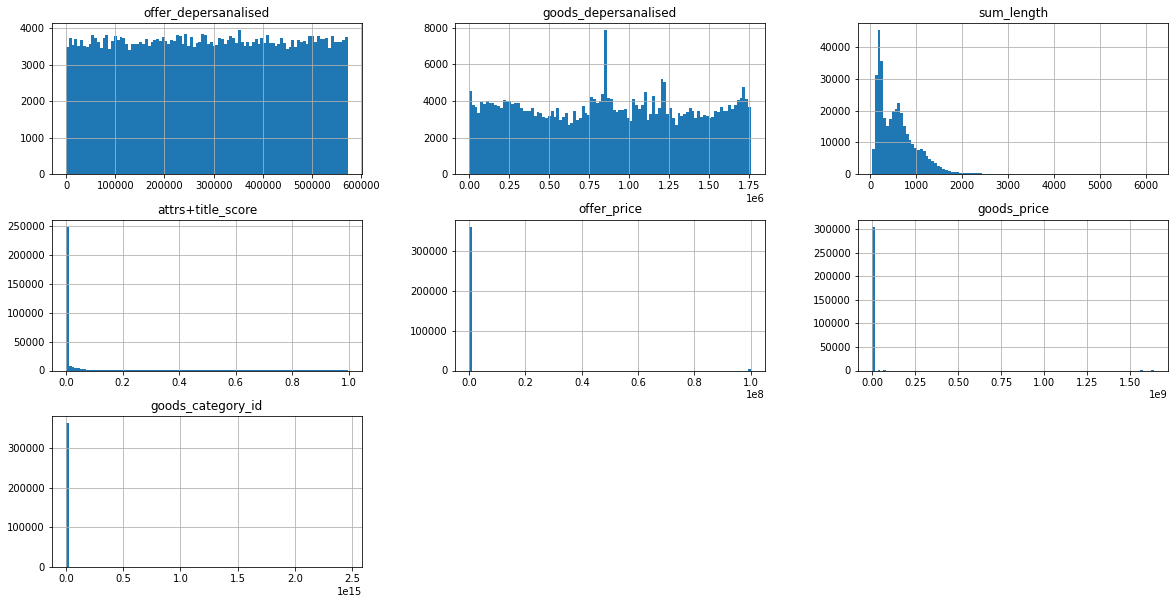

In [6]:
# общая информация по тестовой выборке
info(test)

Посмотрим на баланс классов:

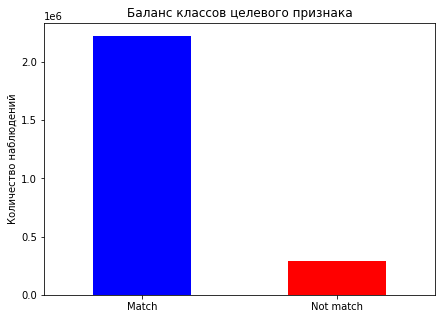

In [7]:
colors = ['blue', 'red']
train['target'].value_counts().plot(kind='bar', figsize=(7, 5), color=colors)
plt.ylabel('Количество наблюдений')
plt.title('Баланс классов целевого признака')
plt.xticks([0, 1], ['Match', 'Not match'], rotation = 0)
plt.show()

Наблюдается явный дисбаланс классов,попробуем решить проблему с помощью настройки гиперпараметров модели (обычно данный вариант приводит к лучшей метрике, чем  upsampling/downsampling). Также стоит попробовать изменить порог классификации. 

Посмотрим на массивы данных:

In [8]:
# создадим словарь с массивами
arrays_dict = {"Вектора изображений товаров ассортимента": goods_image_vectors, 
               "ID векторов изображений товаров ассортимента": goods_image_vectors_id,
               "Вектора изображений товаров предложения":offer_image_vectors,
               "ID векторов изображений товаров предложения":offer_image_vectors_id,
               "Вектора названий+атрибутов товаров ассортимента":goods_title_vectors,
               "ID векторов названий+атрибутов товаров ассортимента":goods_title_vectors_id,
               "Вектора названий+атрибутов товаров предложения":offer_title_vectors,
               "ID векторов названий+атрибутов товаров предложения":offer_title_vectors_id}

# выведем общую информацию о массивах
info_array(arrays_dict)

Вектора изображений товаров ассортимента:
Объем массива: (317707, 256)
Тип данных массива: float32
Размерность массива: 2
Массив не нормализован.
****************************************************************************************************
ID векторов изображений товаров ассортимента:
Объем массива: (317707,)
Тип данных массива: <U7
Размерность массива: 1
Массив не нормализован.
****************************************************************************************************
Вектора изображений товаров предложения:
Объем массива: (457586, 256)
Тип данных массива: float32
Размерность массива: 2
Массив не нормализован.
****************************************************************************************************
ID векторов изображений товаров предложения:
Объем массива: (457586,)
Тип данных массива: <U6
Размерность массива: 1
Массив не нормализован.
****************************************************************************************************
Вектора названий+атриб

### Выводы:

- Основная проблема данных - пропуски. Больше всего пропусков в эмбеддингах изображений товаров. Учитывая что товары могут повторяться в выборках, количество пропусков данного признаку может быть меньше в итоговом датасете. Также есть пропуски в цене товаров ассортимента, в id категорий товаров. Модели градиентного бустинга могут работать с датасетами, в которых присутствуют пропуски, но если итоговое качество будет низким, стоит рассмотреть вариант с заполнением пропусков синтетическими данными (например, с помощью регрессионных моделей).
- В обучающей выборке наблюдается дисбаланс классов, необходимо протестировать варианты с балансом весов классов.
- Вектора эмбеддингов в массивах необходимо будет нормализовать.
- На графиках можно заметить слудующую особенность (обучающая выборка):на гистограмме goods_price есть достаточно большие значения цены, тогда как на гистограмме offer_price значения цены сосредоточены в основном в районе 0.

## Предобработка данных

In [9]:
# функция для нахождения средней косинусной схожести между векторами

def batch_mean_cosine_similarity(vector1, vector2, batch_size):
    num_vectors = vector1.shape[0]
    mean_similarities = []
    for i in range(0, num_vectors, batch_size):
        start = i
        end = min(i + batch_size, num_vectors)
        batch_similarity = cosine_similarity(vector1[start:end], vector2[start:end])
        mean_similarity = np.mean(batch_similarity, axis=1)
        mean_similarities.append(mean_similarity)
    return np.concatenate(mean_similarities)  

Нормализуем эмбеддинги текстов и изображений для стабилизации обучения моделей:

In [10]:
# создаем список массивов, которые необходимо нормализовать
arrays = [goods_image_vectors, goods_title_vectors, offer_image_vectors, offer_title_vectors]

# нормализуем массивы
for i in range(len(arrays)):
    arrays[i] = normalize(arrays[i], norm='l2')
    
    if np.all((arrays[i] >= -1) & (arrays[i] <= 1)):
        print("Массив нормализован.")
    else:
        print("Массив не нормализован.")

# присваиваем нормализованные массивы обратно исходным переменным
goods_image_vectors, goods_title_vectors, offer_image_vectors, offer_title_vectors = arrays

Массив нормализован.
Массив нормализован.
Массив нормализован.
Массив нормализован.


Так как вектора и id соотносятся 1 к 1, создадим 4 датасета с id товара и вектором его изображения, вектором текстовых данных:

In [11]:
# формируем датасеты с эмбендингами и идентификаторами
goods_image = pd.DataFrame({
    'goods_depersanalised': goods_image_vectors_id.astype('int64'),
    'goods_image_vectors': list(goods_image_vectors)
})

goods_title = pd.DataFrame({
    'goods_depersanalised': goods_title_vectors_id.astype('int64'),
    'goods_title_vectors': list(goods_title_vectors)
    })

offer_image= pd.DataFrame({
    'offer_depersanalised': offer_image_vectors_id.astype('int64'),
    'offer_image_vectors': list(offer_image_vectors)
    })

offer_title = pd.DataFrame({
    'offer_depersanalised': offer_title_vectors_id.astype('int64'),
    'offer_title_vectors': list(offer_title_vectors)
    })

Объединим датафреймы с табличными данными и эмбеддингами по id товаров:

In [12]:
# обучающая выборка
data = (
    pd.merge(train, goods_image, on='goods_depersanalised', how='left')
    .merge(goods_title, on='goods_depersanalised', how='left')
    .merge(offer_image, on='offer_depersanalised', how='left')
    .merge(offer_title, on='offer_depersanalised', how='left')
)
# тестовая выборка
data_test = (
    pd.merge(test, goods_image, on='goods_depersanalised', how='left')
    .merge(goods_title, on='goods_depersanalised', how='left')
    .merge(offer_image, on='offer_depersanalised', how='left')
    .merge(offer_title, on='offer_depersanalised', how='left')
)

In [13]:
data.info(), data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2528964 entries, 0 to 2528963
Data columns (total 13 columns):
 #   Column                Dtype  
---  ------                -----  
 0   offer_depersanalised  int64  
 1   goods_depersanalised  int64  
 2   sum_length            int64  
 3   attrs+title_score     float64
 4   offer_price           int64  
 5   goods_price           float64
 6   goods_category_id     float64
 7   target                int64  
 8   id                    object 
 9   goods_image_vectors   object 
 10  goods_title_vectors   object 
 11  offer_image_vectors   object 
 12  offer_title_vectors   object 
dtypes: float64(3), int64(5), object(5)
memory usage: 270.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 365377 entries, 0 to 365376
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   offer_depersanalised  365377 non-null  int64  
 1   goods_depersanalised  3653

(None, None)

При объединении данных исходные выборки увеличились, а значит в данных образовались дубликаты, удалим их:

In [14]:
print('Количество дубликатов в обучающей выборке:', data.shape[0] - train.shape[0])
print('Количество дубликатов в тестовой выборке:', data_test.shape[0] - test.shape[0])

Количество дубликатов в обучающей выборке: 10523
Количество дубликатов в тестовой выборке: 1542


In [15]:
# удаляем дубликаты в обучающей выборке
data.drop_duplicates(subset=['offer_depersanalised','goods_depersanalised','sum_length','attrs+title_score','offer_price',
                              'goods_price','goods_category_id','target', 'id'], inplace=True)

# удаляем дубликаты в тестовой выборке
data_test.drop_duplicates(subset=['offer_depersanalised','goods_depersanalised','sum_length','attrs+title_score','offer_price',
                              'goods_price','goods_category_id','id'], inplace=True)

In [16]:
print('Количество дубликатов в обучающей выборке:', data.shape[0] - train.shape[0])
print('Количество дубликатов в тестовой выборке:', data_test.shape[0] - test.shape[0])

Количество дубликатов в обучающей выборке: 0
Количество дубликатов в тестовой выборке: 0


Посмотрим на получившийся датасет:

In [17]:
data.sample(7)

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id,goods_image_vectors,goods_title_vectors,offer_image_vectors,offer_title_vectors
988814,294774,177403,368,0.038971,857,470.0,14.0,0,294774$177403,NaN,"[-0.1671, -0.0479, 0.05585, -0.1403, 0.0003507...","[0.017706204, 0.023082973, 0.06321741, -0.0780...","[0.01361, -0.1598, -0.0783, 0.0334, -0.04196, ..."
2173321,507987,331062,1066,0.000039,1177,1690.0,8.0,0,507987$331062,NaN,"[0.0004203, -0.0652, 0.0674, -0.1108, -0.04883...","[0.04264329, 0.026936794, 0.089325845, -0.0196...","[-0.059, 0.1653, -0.0884, -0.0665, 0.001812, 0..."
2072995,18882,201951,956,0.780273,101,209.0,13.0,0,18882$201951,NaN,"[0.0708, -0.0153, -0.09753, 0.21, -0.03366, -0...",NaN,"[0.1802, 0.04187, 0.01775, 0.07086, -0.3484, 0..."
98011,349991,269552,118,0.001060,65203,5999.0,21.0,0,349991$269552,NaN,"[0.02798, -0.05994, -0.05966, 0.04135, -0.2498...","[0.09100595, 0.016220436, 0.030880213, 0.06426...","[0.04666, 0.1107, -0.1636, -0.3003, -0.004757,..."
2095357,328991,1561522,979,0.000222,871,665.0,2.0,0,328991$1561522,NaN,"[0.1794, -0.0406, 0.01791, 0.0378, -0.0438, -0...","[0.1072131, -0.016695905, 0.02824522, -0.04145...","[0.01511, 0.1328, -0.1287, 0.077, 0.02934, 0.0..."
496106,357367,1526279,206,0.402100,3213,3847.0,5.0,1,357367$1526279,"[-0.008712032, 0.0003542991, -0.020607851, -0....","[-0.08386, -0.009735, -0.1653, -0.031, -0.0225...",NaN,"[-0.1572, -0.0448, -0.0009475, 0.1375, 0.2236,..."
668255,457438,1475791,239,0.000036,850,NaN,5.0,0,457438$1475791,NaN,"[-0.08417, 0.138, 0.1365, 0.07935, -0.2656, 0....",NaN,"[-0.02806, -0.02751, 0.1681, 0.03564, -0.08185..."


In [18]:
data.isnull().sum().sort_values(ascending=False)

goods_image_vectors     1972702
offer_image_vectors      508182
goods_price              407287
goods_category_id           833
offer_depersanalised          0
goods_depersanalised          0
sum_length                    0
attrs+title_score             0
offer_price                   0
target                        0
id                            0
goods_title_vectors           0
offer_title_vectors           0
dtype: int64

In [19]:
data_test.isnull().sum().sort_values(ascending=False)

goods_image_vectors     285461
offer_image_vectors      72580
goods_price              58971
goods_category_id          131
offer_depersanalised         0
goods_depersanalised         0
sum_length                   0
attrs+title_score            0
offer_price                  0
id                           0
goods_title_vectors          0
offer_title_vectors          0
dtype: int64

In [20]:
print('Количество пропусков в goods_image_vectors (обучающая выборка),%:', round(data['goods_image_vectors'].isna().sum()/len(data)*100,2))
print('Количество пропусков в goods_image_vectors (тестовая выборка),%:', round(data_test['goods_image_vectors'].isna().sum()/len(data_test)*100,2))

Количество пропусков в goods_image_vectors (обучающая выборка),%: 78.33
Количество пропусков в goods_image_vectors (тестовая выборка),%: 78.46


Ранее сделанное предположение подтвердилось - в итоговых датасетах большинство векторов изображений отсутствует. Оставим пропуски в данных и посмотрим на метрики без заполнения пропусков.

Для обучения моделей будем использовать признак, сформированный на основе эмбеддингов - косинусную схожесть. Для того чтобы ее вычислить, заполним пропущенные значения векторов на заглушку - нулевой вектор того же размера:

In [21]:
# нулевой вектор
zero_vector = np.zeros(256)

# заполняем пропуски эмбеддингов в обучающей выборке
data['goods_image_vectors'] = data['goods_image_vectors'].apply(lambda x: zero_vector if isinstance(x, float) else x)
data['offer_image_vectors'] = data['offer_image_vectors'].apply(lambda x: zero_vector if isinstance(x, float) else x)

# заполняем пропуски эмбеддингов в тестовой выборке
data_test['goods_image_vectors'] = data_test['goods_image_vectors'].apply(lambda x: zero_vector if isinstance(x, float) else x)
data_test['offer_image_vectors'] = data_test['offer_image_vectors'].apply(lambda x: zero_vector if isinstance(x, float) else x)

print('Обучающая выборка:')
print(data.isnull().sum().sort_values(ascending=False))
print('')
print('Тестовая выборка:')
data_test.isnull().sum().sort_values(ascending=False)

Обучающая выборка:
goods_price             407287
goods_category_id          833
offer_depersanalised         0
goods_depersanalised         0
sum_length                   0
attrs+title_score            0
offer_price                  0
target                       0
id                           0
goods_image_vectors          0
goods_title_vectors          0
offer_image_vectors          0
offer_title_vectors          0
dtype: int64

Тестовая выборка:


goods_price             58971
goods_category_id         131
offer_depersanalised        0
goods_depersanalised        0
sum_length                  0
attrs+title_score           0
offer_price                 0
id                          0
goods_image_vectors         0
goods_title_vectors         0
offer_image_vectors         0
offer_title_vectors         0
dtype: int64

Из заполненных данных сформируем массивы для вычисления косинусной схожести:

In [22]:
# обучающая выборка
goods_title_vectors = np.array(data['goods_title_vectors'].tolist())
offer_title_vectors = np.array(data['offer_title_vectors'].tolist())
offer_image_vectors_train = np.array(data['offer_image_vectors'].tolist())
goods_image_vectors_train = np.array(data['goods_image_vectors'].tolist())

# тестовая выборка
goods_title_vectors_test = np.array(data_test['goods_title_vectors'].tolist())
offer_title_vectors_test = np.array(data_test['offer_title_vectors'].tolist())
offer_image_vectors_test = np.array(data_test['offer_image_vectors'].tolist())
goods_image_vectors_test = np.array(data_test['goods_image_vectors'].tolist())

Вычислим среднюю косинусную схожесть между векторами изображений и текстов и добавим соответствующие столбцы в итоговые датасеты:

In [23]:
batch_size = 1000

# средняя косинусная схожесть текстов (обучающая выборка)
data['mean_similarity_title'] = batch_mean_cosine_similarity(goods_title_vectors, offer_title_vectors, batch_size)

# средняя косинусная схожесть текстов (тестовая выборка)
data_test['mean_similarity_title'] = batch_mean_cosine_similarity(goods_title_vectors_test, offer_title_vectors_test, batch_size)

In [24]:
# средняя косинусная схожесть изображений (обучающая выборка)
data['mean_similarity_img'] = batch_mean_cosine_similarity(goods_image_vectors_train, offer_image_vectors_train, batch_size)

# средняя косинусная схожесть изображений (тестовая выборка)
data_test['mean_similarity_img'] = batch_mean_cosine_similarity(goods_image_vectors_test, offer_image_vectors_test, batch_size)

In [50]:
# меняем заглушки на пропуски в столбце mean_similarity_img
data['mean_similarity_img'] = data['mean_similarity_img'].replace(0.0, np.nan)
data_test['mean_similarity_img'] = data_test['mean_similarity_img'].replace(0.0, np.nan)

## Формирование выборок

Сформируем 2 выборки - обучающую и валидационную - из тренировочных данных.

In [51]:
# удалим вектора и id, которые не будем использовать для обучения (обучающая выборка)
features = data.drop(['id', 'goods_image_vectors', 'offer_depersanalised', 'goods_depersanalised',
                      'goods_title_vectors', 'offer_image_vectors','offer_title_vectors', 'target'], axis=1)

target = data['target']

# удалим вектора и id, которые не будем использовать для обучения (тестовая выборка)
features_test = data_test.drop(['id', 'goods_image_vectors', 'offer_depersanalised', 'goods_depersanalised',
                      'goods_title_vectors', 'offer_image_vectors','offer_title_vectors'], axis=1)

In [52]:
RANDOM_STATE = 123

In [53]:
# делим данные на выборки в соотношении 80/20, сохраняя баланс классов целевого признака
features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                              target,
                                                                              stratify = target,
                                                                              test_size=0.2,
                                                                              random_state=RANDOM_STATE)

## Обучение моделей

In [54]:
# функция для обучения моделей и сравнения результатов

def model_selection(models_dict, features_train, target_train, features_valid, target_valid):
    
    results_df = pd.DataFrame(columns=['Model Name', 'F1-Score', 'Precision', 'Recall'])
    
    for model_name, model in models_dict.items():
        
        model.fit(features_train, target_train)
        preds = model.predict(features_valid)
        f1 = round(f1_score(target_valid, preds), 5)
        precision = round(precision_score(target_valid, preds), 5)
        recall = round(recall_score(target_valid, preds), 5)
        
        results_df = results_df.append({'Model Name': model_name,
                                        'F1-Score': f1,
                                        'Precision': precision,
                                        'Recall': recall}, ignore_index=True)
        
    return results_df


Сравним результаты трех моделей градиентного бустинга с дефолтными параметрами:

In [55]:
# cоздадим словарь с моделями градиентного бустинга и их гиперпараметрами
models_dict = {
    'LGBMClassifier': lgb.LGBMClassifier(objective='binary', n_estimators=1000, random_state=RANDOM_STATE),
    'XGBClassifier': xgb.XGBClassifier(objective='binary:logistic', n_estimators=1000, random_state=RANDOM_STATE),
    'CatBoostClassifier': CatBoostClassifier(eval_metric='F1', verbose=False, iterations=1000, random_state=RANDOM_STATE)
}

# применим функцию для обучения и оценки моделей градиентного бустинга
results_table = model_selection(models_dict, features_train, target_train, features_valid, target_valid)

display(results_table)

,Model Name,F1-Score,Precision,Recall
0,LGBMClassifier,0.91346,0.88683,0.94174
1,XGBClassifier,0.91687,0.89394,0.94100
2,CatBoostClassifier,0.91666,0.89238,0.94230


Лучший результат показал XGBClassifier. CatBoostClassifier близок по f1-score, обогнал по полноте XGBClassifier, но уступил по точности. Можно рассмотреть вариант с ансамблем моделей. 

Попробуем **CatBoostClassifier с гиперпараметром auto_class_weights='SqrtBalanced'** (вес класса на основе общего количества объектов в каждом классе):

In [56]:
# CatBoostClassifier с гиперпараметром auto_class_weights
models_dict = {
    'CatBoostClassifier balanced': CatBoostClassifier(eval_metric='F1', verbose=False, 
                                                      iterations=1000, auto_class_weights='SqrtBalanced', 
                                                      random_state=RANDOM_STATE)
}
catboost_balanced = model_selection(models_dict, features_train, target_train, features_valid, target_valid)

# добавляем в сравнительную таблицу результаты обучения
results_table = pd.concat([results_table, catboost_balanced], ignore_index=True)
display(results_table)

,Model Name,F1-Score,Precision,Recall
0,LGBMClassifier,0.91346,0.88683,0.94174
1,XGBClassifier,0.91687,0.89394,0.94100
2,CatBoostClassifier,0.91666,0.89238,0.94230
3,CatBoostClassifier balanced,0.91304,0.85964,0.97351


Баланс классов не дал прироста метрики, а наоборот ухудшил ее. В итоге упала точность, но выросла полнота. В дальнейшем не будем использовать балансировку веса классов.

Попробуем **добавить новый признак - отношение цены предложения к цене товара из ассортимента:**

In [57]:
features_train['price_ratio'] = features_train['offer_price']/features_train['goods_price']
features_valid['price_ratio'] = features_valid['offer_price']/features_valid['goods_price']

models_dict = {
    'CatBoostClassifier with price ratio': CatBoostClassifier(eval_metric='F1', verbose=False, iterations=1000, random_state=RANDOM_STATE)
}
catboost_price_ratio = model_selection(models_dict, features_train, target_train, features_valid, target_valid)

results_table = pd.concat([results_table, catboost_price_ratio], ignore_index=True)
display(results_table)

,Model Name,F1-Score,Precision,Recall
0,LGBMClassifier,0.91346,0.88683,0.94174
1,XGBClassifier,0.91687,0.89394,0.94100
2,CatBoostClassifier,0.91666,0.89238,0.94230
3,CatBoostClassifier balanced,0.91304,0.85964,0.97351
4,CatBoostClassifier with price ratio,0.91765,0.89373,0.94290


Метрика увеличилась, выросла и точность, и полнота. Добавим признак в тестовую и обучающую выборки:

In [58]:
features['price_ratio'] = features['offer_price']/features['goods_price']
features_test['price_ratio'] = features_test['offer_price']/features_test['goods_price']

**Попробуем добавить еще один признак - разницу в цене:**

In [59]:
features_train['price_difference'] = features_train['offer_price'] - features_train['goods_price']
features_valid['price_difference'] = features_valid['offer_price'] - features_valid['goods_price']

models_dict = {
    'CatBoostClassifier with price difference': CatBoostClassifier(eval_metric='F1', verbose=False, iterations=1000, random_state=RANDOM_STATE)
}
catboost_price_difference = model_selection(models_dict, features_train, target_train, features_valid, target_valid)

results_table = pd.concat([results_table, catboost_price_difference], ignore_index=True)
display(results_table)

,Model Name,F1-Score,Precision,Recall
0,LGBMClassifier,0.91346,0.88683,0.94174
1,XGBClassifier,0.91687,0.89394,0.94100
2,CatBoostClassifier,0.91666,0.89238,0.94230
3,CatBoostClassifier balanced,0.91304,0.85964,0.97351
4,CatBoostClassifier with price ratio,0.91765,0.89373,0.94290
5,CatBoostClassifier with price difference,0.91777,0.89380,0.94307


Метрика незначительно увеличилась, добавим в тестовую и обучающую выборки разницу в цене:

In [60]:
features['price_difference'] = features['offer_price'] - features['goods_price']
features_test['price_difference'] = features_test['offer_price'] - features_test['goods_price']

Проверим корреляцию между предикторами:

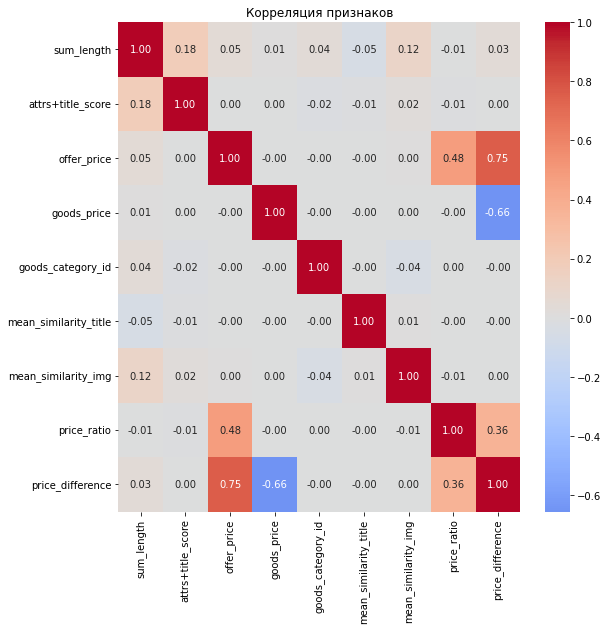

In [61]:
plt.figure(figsize=(9,9))
sns.heatmap(features_train.corr(), 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.2f')
plt.title('Корреляция признаков')  
plt.show()

В данных теперь есть мультиколлинеарность (price_difference и offer_price, goods_price и price_difference), но разница в цене дала прирост метрики, а модели градиентного бустинга способны справится с мультиколлинеарностью, так что оставим все признаки в датасете.

Протестируем **ансамбль из XGBClassifier и CatBoostClassifier с мягким голосованием**:

In [62]:
model1 = xgb.XGBClassifier(random_state=RANDOM_STATE, objective='binary:logistic', n_estimators=1000)
model2 = CatBoostClassifier(random_state=RANDOM_STATE, eval_metric='F1', verbose=False, iterations = 1000)

# создадим ансамбль из моделей градиентного бустинга
ensemble = VotingClassifier(estimators=[('xgb', model1), ('catboost', model2)], voting='soft')
                                   
                                        
models_dict = {
    'Ensemble(xgb+catboost)': ensemble
}
ensemble_results = model_selection(models_dict, features_train, target_train, features_valid, target_valid)

results_table = pd.concat([results_table, ensemble_results], ignore_index=True)
display(results_table)

,Model Name,F1-Score,Precision,Recall
0,LGBMClassifier,0.91346,0.88683,0.94174
1,XGBClassifier,0.91687,0.89394,0.94100
2,CatBoostClassifier,0.91666,0.89238,0.94230
3,CatBoostClassifier balanced,0.91304,0.85964,0.97351
4,CatBoostClassifier with price ratio,0.91765,0.89373,0.94290
5,CatBoostClassifier with price difference,0.91777,0.89380,0.94307
6,Ensemble(xgb+catboost),0.91928,0.89548,0.94439


Ансамбль дает неплохой прирост метрики, стоит рассмотреть его в качестве финальной модели.

### Порог классификации

В качестве одного из вариантов решения проблемы дисбаланса классов можно попробовать подобрать оптимальный порог классификации. Попробуем найти его для ансамбля и посмотрим, увеличит ли данный метод метрику:

In [63]:
ensemble.fit(features_train, target_train)

forecast = ensemble.predict_proba(features_valid)
probs = forecast[:, 1]
thresholds = np.arange (0, 1, 0.001)

def to_labels(pos_probs, threshold):
 return (pos_probs >= threshold).astype('int')

scores = [f1_score(target_valid, to_labels(probs, t)) for t in thresholds]

ix = np.argmax(scores)
print('Порог классификации: %.3f, F1-Score: %.5f' % (thresholds[ix], scores[ix]))

Порог классификации: 0.460, F1-Score: 0.91998


Измененный порог действительно дает прирост метрики. Используем его при предсказании на тестовых данных.

### Optuna

Попробуем подобрать оптимальные гиперпараметры для catboost'а и xgb с помощью библиотеки optuna:

In [113]:
# определяем целевую функцию objective
def objective(trial):
    
    # словарь параметров
    params = {
        'eval_metric': 'F1',
        'random_state': 123,
        'iterations' : trial.suggest_int("iterations", 1000, 5000),
        'depth' : trial.suggest_int("depth", 4, 10),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    }
    
    model = CatBoostClassifier(**params)
    model.fit(features_train,target_train, verbose=500)
    predictions = model.predict(features_valid)
    f1_catboost = f1_score(target_valid, predictions)
    return f1_catboost

In [114]:
# создаем объект обучения
study = optuna.create_study(direction='maximize')

# запускаем оптимизацию целевой функции objective на 7 итераций
study.optimize(objective, n_trials=7)
print('Best hyperparameters:', study.best_params)
print('Best F1-Score:', study.best_value)

[I 2024-02-13 16:29:12,987] A new study created in memory with name: no-name-9177b19e-a810-4338-a898-28e672ddee9c


0:	learn: 0.9081442	total: 126ms	remaining: 7m 23s
500:	learn: 0.9127791	total: 59.3s	remaining: 5m 55s
1000:	learn: 0.9144637	total: 1m 56s	remaining: 4m 52s
1500:	learn: 0.9156084	total: 2m 55s	remaining: 3m 54s
2000:	learn: 0.9163033	total: 3m 53s	remaining: 2m 56s
2500:	learn: 0.9169460	total: 4m 52s	remaining: 1m 57s
3000:	learn: 0.9174463	total: 5m 49s	remaining: 59s
3500:	learn: 0.9180116	total: 6m 48s	remaining: 699ms
3506:	learn: 0.9180318	total: 6m 48s	remaining: 0us


[I 2024-02-13 16:36:03,306] Trial 0 finished with value: 0.9166529483422777 and parameters: {'iterations': 3507, 'depth': 8, 'learning_rate': 0.00623894130296484}. Best is trial 0 with value: 0.9166529483422777.


0:	learn: 0.9081442	total: 119ms	remaining: 8m 54s
500:	learn: 0.9109262	total: 1m	remaining: 8m 3s
1000:	learn: 0.9120235	total: 2m 1s	remaining: 7m 2s
1500:	learn: 0.9129366	total: 3m	remaining: 5m 59s
2000:	learn: 0.9134957	total: 3m 59s	remaining: 4m 57s
2500:	learn: 0.9140859	total: 4m 57s	remaining: 3m 56s
3000:	learn: 0.9146284	total: 5m 56s	remaining: 2m 56s
3500:	learn: 0.9150806	total: 6m 55s	remaining: 1m 57s
4000:	learn: 0.9153796	total: 7m 54s	remaining: 57.8s
4488:	learn: 0.9157307	total: 8m 51s	remaining: 0us


[I 2024-02-13 16:44:56,631] Trial 1 finished with value: 0.9151142803095726 and parameters: {'iterations': 4489, 'depth': 8, 'learning_rate': 0.002220431056804187}. Best is trial 0 with value: 0.9166529483422777.


0:	learn: 0.9083041	total: 182ms	remaining: 11m 33s
500:	learn: 0.9262605	total: 1m 32s	remaining: 10m 10s
1000:	learn: 0.9333160	total: 3m 4s	remaining: 8m 37s
1500:	learn: 0.9392001	total: 4m 37s	remaining: 7m 4s
2000:	learn: 0.9446971	total: 6m 9s	remaining: 5m 32s
2500:	learn: 0.9492900	total: 7m 41s	remaining: 4m
3000:	learn: 0.9535803	total: 9m 13s	remaining: 2m 27s
3500:	learn: 0.9576030	total: 10m 44s	remaining: 55.4s
3801:	learn: 0.9596560	total: 11m 39s	remaining: 0us


[I 2024-02-13 16:56:38,963] Trial 2 finished with value: 0.9183322018181518 and parameters: {'iterations': 3802, 'depth': 10, 'learning_rate': 0.08248830412793505}. Best is trial 2 with value: 0.9183322018181518.


0:	learn: 0.9081442	total: 95.1ms	remaining: 2m 16s
500:	learn: 0.9098775	total: 48s	remaining: 1m 29s
1000:	learn: 0.9097220	total: 1m 35s	remaining: 41.2s
1433:	learn: 0.9098998	total: 2m 15s	remaining: 0us


[I 2024-02-13 16:58:55,560] Trial 3 finished with value: 0.9092509129190379 and parameters: {'iterations': 1434, 'depth': 5, 'learning_rate': 0.0013110059752069506}. Best is trial 2 with value: 0.9183322018181518.


0:	learn: 0.9081442	total: 102ms	remaining: 5m 56s
500:	learn: 0.9139798	total: 42.1s	remaining: 4m 11s
1000:	learn: 0.9151204	total: 1m 23s	remaining: 3m 28s
1500:	learn: 0.9159738	total: 2m 5s	remaining: 2m 46s
2000:	learn: 0.9165836	total: 2m 46s	remaining: 2m 4s
2500:	learn: 0.9170404	total: 3m 28s	remaining: 1m 22s
3000:	learn: 0.9174720	total: 4m 9s	remaining: 40.7s
3489:	learn: 0.9177822	total: 4m 50s	remaining: 0us


[I 2024-02-13 17:03:47,643] Trial 4 finished with value: 0.916154004529545 and parameters: {'iterations': 3490, 'depth': 4, 'learning_rate': 0.03665758665150615}. Best is trial 2 with value: 0.9183322018181518.


0:	learn: 0.9084360	total: 126ms	remaining: 3m 1s
500:	learn: 0.9110371	total: 1m 4s	remaining: 2m 1s
1000:	learn: 0.9117893	total: 2m 9s	remaining: 56.9s
1440:	learn: 0.9126126	total: 3m 6s	remaining: 0us


[I 2024-02-13 17:06:55,623] Trial 5 finished with value: 0.9119261231062474 and parameters: {'iterations': 1441, 'depth': 9, 'learning_rate': 0.001509080884036847}. Best is trial 2 with value: 0.9183322018181518.


0:	learn: 0.9083041	total: 180ms	remaining: 14m 31s
500:	learn: 0.9231187	total: 1m 31s	remaining: 13m 12s
1000:	learn: 0.9289953	total: 3m 2s	remaining: 11m 41s
1500:	learn: 0.9334810	total: 4m 32s	remaining: 10m 8s
2000:	learn: 0.9373479	total: 6m 3s	remaining: 8m 37s
2500:	learn: 0.9410607	total: 7m 34s	remaining: 7m 6s
3000:	learn: 0.9448523	total: 9m 4s	remaining: 5m 35s
3500:	learn: 0.9481661	total: 10m 34s	remaining: 4m 4s
4000:	learn: 0.9513674	total: 12m 3s	remaining: 2m 33s
4500:	learn: 0.9542718	total: 13m 33s	remaining: 1m 3s
4849:	learn: 0.9561117	total: 14m 35s	remaining: 0us


[I 2024-02-13 17:21:35,038] Trial 6 finished with value: 0.9191671769748929 and parameters: {'iterations': 4850, 'depth': 10, 'learning_rate': 0.05683965228786707}. Best is trial 6 with value: 0.9191671769748929.


Best hyperparameters: {'iterations': 4850, 'depth': 10, 'learning_rate': 0.05683965228786707}
Best F1-Score: 0.9191671769748929


In [117]:
def objective(trial):
    
    # словарь параметров
    params = {
        'objective': 'binary:logistic',
        'random_state': RANDOM_STATE,
        'n_estimators' : trial.suggest_int("n_estimators", 1000, 5000),
        'max_depth' : trial.suggest_int("max_depth", 4, 10),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    }
    
    model = xgb.XGBClassifier(**params)
    model.fit(features_train,target_train, verbose=500)
    predictions = model.predict(features_valid)
    f1_xgb = f1_score(target_valid, predictions)
    return f1_xgb

In [ ]:
study = optuna.create_study(direction='maximize')

# запускаем оптимизацию целевой функции objective на 7 итераций
study.optimize(objective, n_trials=7)
print('Best hyperparameters:', study.best_params)
print('Best F1-Score:', study.best_value)

[I 2024-02-13 17:59:24,395] A new study created in memory with name: no-name-d08e0dee-0ae5-4332-940c-b4a7ec5ee052
[I 2024-02-13 18:20:01,255] Trial 0 finished with value: 0.9200026412664872 and parameters: {'n_estimators': 1001, 'max_depth': 9, 'learning_rate': 0.06063685751953226}. Best is trial 0 with value: 0.9200026412664872.
[I 2024-02-13 19:50:46,177] Trial 1 finished with value: 0.9195415567282322 and parameters: {'n_estimators': 4051, 'max_depth': 10, 'learning_rate': 0.00668361092025405}. Best is trial 0 with value: 0.9200026412664872.
[I 2024-02-13 20:03:53,098] Trial 2 finished with value: 0.9094695237473052 and parameters: {'n_estimators': 1602, 'max_depth': 4, 'learning_rate': 0.0010554630080913624}. Best is trial 0 with value: 0.9200026412664872.
[I 2024-02-13 20:34:55,091] Trial 3 finished with value: 0.9171226104152933 and parameters: {'n_estimators': 3536, 'max_depth': 4, 'learning_rate': 0.018216852569975097}. Best is trial 0 with value: 0.9200026412664872.
[I 2024-02

Best hyperparameters: {'n_estimators': 1001, 'max_depth': 9, 'learning_rate': 0.06063685751953226}
Best F1-Score: 0.9200026412664872


Протестируем ансамбль с подобранными гиперпараметрами:

In [64]:
model1 = xgb.XGBClassifier(random_state=RANDOM_STATE, objective='binary:logistic', n_estimators=1001, 
                           max_depth = 9, learning_rate = 0.06063685751953226)
model2 = CatBoostClassifier(random_state=RANDOM_STATE, eval_metric='F1', verbose=False, iterations = 4850, 
                            depth = 10, learning_rate = 0.05683965228786707)

# создадим ансамбль из моделей градиентного бустинга
ensemble = VotingClassifier(estimators=[('xgb', model1), ('catboost', model2)], voting='soft')
                                                                      
models_dict = {
    'Ensemble(xgb+catboost)': ensemble
}
ensemble_final = model_selection(models_dict, features_train, target_train, features_valid, target_valid)

results_table = pd.concat([results_table, ensemble_final], ignore_index=True)
display(results_table)

,Model Name,F1-Score,Precision,Recall
0,LGBMClassifier,0.91346,0.88683,0.94174
1,XGBClassifier,0.91687,0.89394,0.94100
2,CatBoostClassifier,0.91666,0.89238,0.94230
3,CatBoostClassifier balanced,0.91304,0.85964,0.97351
4,CatBoostClassifier with price ratio,0.91765,0.89373,0.94290
5,CatBoostClassifier with price difference,0.91777,0.89380,0.94307
6,Ensemble(xgb+catboost),0.91928,0.89548,0.94439
7,Ensemble(xgb+catboost),0.92043,0.89679,0.94534


Метрика  улучшилась по сравнению с ансамблем без настройки гиперпараметров, точность и полнота увеличились. В качестве финальной модели будем использовать данный ансамбль.

## Итоговая модель

Обучим финальную модель на всей обучающей выборке:

In [66]:
# финальная модель
model_final = VotingClassifier(estimators=[('xgb', model1), ('catboost', model2)], voting='soft')

# обучаем модель на всей тренировочной выборке и делаем предсказания на тестовой
model_final.fit(features, target)
model_final_preds = model_final.predict(features_test)

# перезаписываем предсказания в примере для сабмита
predictions = sample_submission.drop(['target'], axis =1)
predictions['target'] = model_final_preds

Применим оптимальный порог классификации для финальных предсказаний:

In [67]:
final_probs = model_final.predict_proba(features_test)
y_pred = (final_probs[:, 1] >= 0.460).astype(int)
predictions['target'] = y_pred

Сохраним получившиеся предсказания в файле **predictions_final.csv**:

In [68]:
predictions.to_csv('predictions_final.csv', index = False)

## Итоги

До дедлайна соревнования в качестве финальной модели был выбран catboost, обученный на 5000 деревьев. К предсказаниям применен подобранный порог классификации:
- Public Score составил **0.91962**
- Private Score составил **0.9199**

После завершения соревнования решение было доработано и в качестве финальной модели был выбран ансамбль (catboost+xgb c подобранными гиперпараметрами), также был применен оптимальный порог классификации:
- Public Score составил **0.92129**
- Private Score составил **0.92132**

**Полезные решения:**

- использование ансамбля моделей с мягким голосованием;
- генерация новых признаков (отношение и разница цен);
- подбор оптимальных гиперпараметров для моделей, входящих в ансамбль;
- подбор оптимального порога классификации.

**Бесполезные решения:**

- изменение весов классов с дефолтных (вес каждого класса равен 1) на веса классов на основе общего количества объектов в каждом классе.